In [1]:
# Parameters
S0 = 100.0
mu = 0.05
sigma = 0.20
corr = 0.70
r = 0.02
T = 1.0
n_steps = 252
n_paths = 50_000
seed = 42

strikes = [80.0, 90.0, 100.0, 110.0, 120.0]
maturities = [0.25, 0.50, 1.00]
K_atm = S0
T_ref = maturities[-1]

# Portfolio VaR / ES parameters
T_var = 1.0 / 252.0
n_steps_var = 1
n_paths_var = 30_000
seed_var = 123

S0_vec = [100.0, 95.0, 105.0]
sigma_vec = [0.20, 0.25, 0.30]
mu_vec = [0.00, 0.00, 0.00]
corr_matrix = [
    [1.00, 0.30, 0.20],
    [0.30, 1.00, 0.10],
    [0.20, 0.10, 1.00],
]
w = [0.40, 0.30, 0.30]
alpha_list = [0.90, 0.95, 0.975, 0.99]
alpha_var = 0.95

# PDE benchmark parameters
T_pde = 1.0
n_S_pde = 300
n_t_pde = 300
pde_S_max_mult = 5.0
n_paths_mc_pde = 40_000
seed_pde = 77

# Preserve portfolio params for later sections
S0_vec_var = S0_vec
sigma_vec_var = sigma_vec
mu_vec_var = mu_vec
corr_matrix_var = corr_matrix
w_var = w


In [2]:
import os
import sys


parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, lognorm, norm
from src.gbm import simulate_gbm_paths, simulate_correlated_gbm_paths, simulate_gbm_terminal
from src.pricing import black_scholes_call, mc_european_call
from src.payoffs import payoff_call
from src.greeks import (
    bs_delta_call,
    bs_gamma,
    bs_vega,
    delta_fd_call,
    delta_pathwise_call,
    gamma_fd_call,
    vega_fd_call,
)
from src.risk_metrics import (
    empirical_es,
    empirical_var,
    simulate_portfolio_pnl,
    var_es_curve,
)
from src.pde_bs_fd import price_bs_pde_cn, solve_bs_pde_cn


In [4]:
figures_dir = os.path.join(parent_dir, "figures", "notebooks", "00_core_validation")
section_dirs = {
    "gbm": os.path.join(figures_dir, "01_gbm_validation"),
    "corr": os.path.join(figures_dir, "02_correlated_gbm"),
    "pricing": os.path.join(figures_dir, "03_european_pricing"),
    "ci": os.path.join(figures_dir, "04_confidence_intervals"),
    "vr": os.path.join(figures_dir, "05_variance_reduction"),
    "payoff": os.path.join(figures_dir, "06_discounted_payoff"),
    "greeks": os.path.join(figures_dir, "07_greeks_validation"),
    "risk": os.path.join(figures_dir, "08_portfolio_risk"),
    "pde": os.path.join(figures_dir, "09_pde_bs_fd"),
}
for path in section_dirs.values():
    os.makedirs(path, exist_ok=True)

sns.set_theme(style="whitegrid")
np.set_printoptions(precision=4, suppress=True)


# 00 Core Validation

This notebook validates GBM simulation, correlated GBM, Monte Carlo pricing, and
confidence intervals against Black-Scholes benchmarks.


## 1) GBM validation: empirical moments vs theory


H=0.25: mean=101.2412 (theory 101.2578), var=101.6913 (theory 103.0459)
H=0.50: mean=102.4859 (theory 102.5315), var=211.4959 (theory 212.3708)
H=1.00: mean=105.1564 (theory 105.1271), var=451.7386 (theory 451.0288)


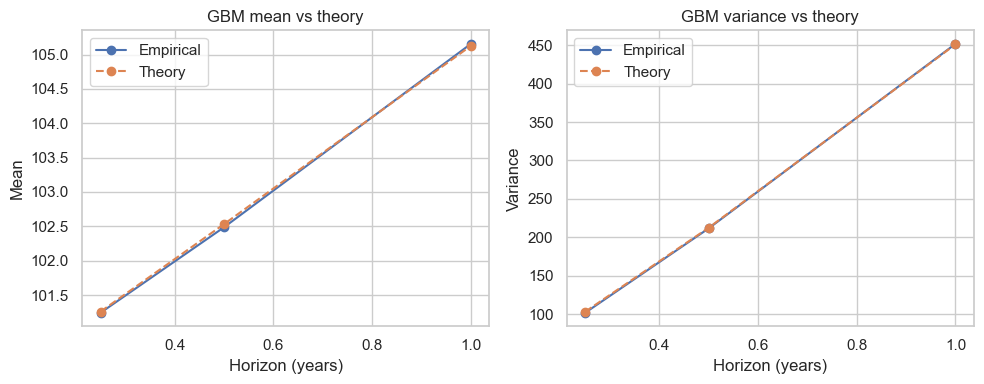

In [5]:
t_grid, paths = simulate_gbm_paths(
    S0=S0,
    mu=mu,
    sigma=sigma,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=seed,
)

horizons = [h for h in maturities if h <= T]
indices = [int(round(h / T * n_steps)) for h in horizons]

emp_means = []
emp_vars = []
theo_means = []
theo_vars = []

for h, idx in zip(horizons, indices):
    S_t = paths[:, idx]
    emp_means.append(S_t.mean())
    emp_vars.append(S_t.var(ddof=1))
    theo_means.append(S0 * np.exp(mu * h))
    theo_vars.append((S0**2) * np.exp(2 * mu * h) * (np.exp(sigma**2 * h) - 1.0))

for h, m_e, m_t, v_e, v_t in zip(horizons, emp_means, theo_means, emp_vars, theo_vars):
    print(f"H={h:.2f}: mean={m_e:.4f} (theory {m_t:.4f}), var={v_e:.4f} (theory {v_t:.4f})")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(horizons, emp_means, marker="o", label="Empirical")
axes[0].plot(horizons, theo_means, marker="o", linestyle="--", label="Theory")
axes[0].set_xlabel("Horizon (years)")
axes[0].set_ylabel("Mean")
axes[0].set_title("GBM mean vs theory")
axes[0].legend()

axes[1].plot(horizons, emp_vars, marker="o", label="Empirical")
axes[1].plot(horizons, theo_vars, marker="o", linestyle="--", label="Theory")
axes[1].set_xlabel("Horizon (years)")
axes[1].set_ylabel("Variance")
axes[1].set_title("GBM variance vs theory")
axes[1].legend()

fig.tight_layout()
fig.savefig(os.path.join(section_dirs["gbm"], "gbm_moments_vs_theory.png"), dpi=150)
plt.show()

### GBM sample paths


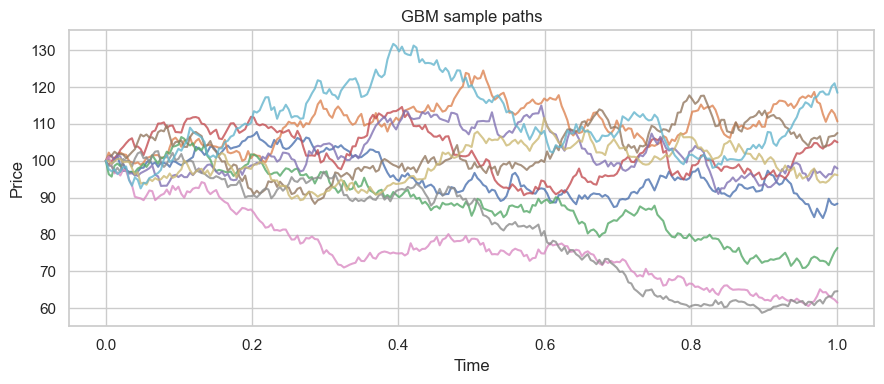

In [6]:
n_plot_paths = 10
plt.figure(figsize=(9, 4))
for i in range(n_plot_paths):
    plt.plot(t_grid, paths[i], alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("GBM sample paths")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["gbm"], "gbm_sample_paths.png"), dpi=150)
plt.show()

### GBM terminal distribution


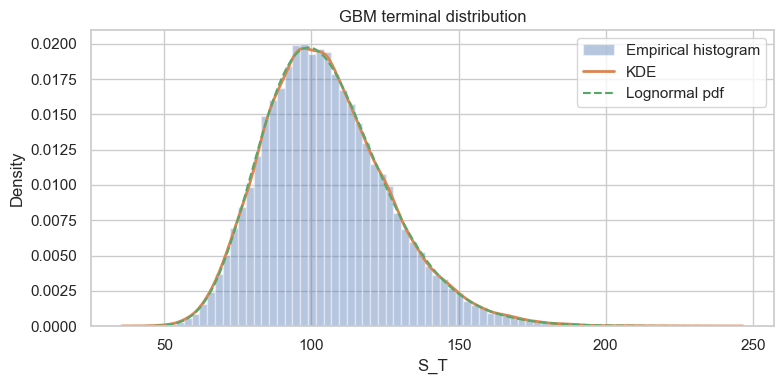

In [7]:
S_T = paths[:, -1]

plt.figure(figsize=(8, 4))
plt.hist(S_T, bins=80, density=True, alpha=0.4, label="Empirical histogram")

kde = gaussian_kde(S_T)
x_vals = np.linspace(S_T.min(), S_T.max(), 500)
plt.plot(x_vals, kde(x_vals), label="KDE", linewidth=2)

m = np.log(S0) + (mu - 0.5 * sigma**2) * T
v = sigma**2 * T
pdf = lognorm.pdf(x_vals, s=np.sqrt(v), scale=np.exp(m))
plt.plot(x_vals, pdf, label="Lognormal pdf", linestyle="--")

plt.xlabel("S_T")
plt.ylabel("Density")
plt.title("GBM terminal distribution")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["gbm"], "gbm_terminal_distribution.png"), dpi=150)
plt.show()

### Log terminal distribution


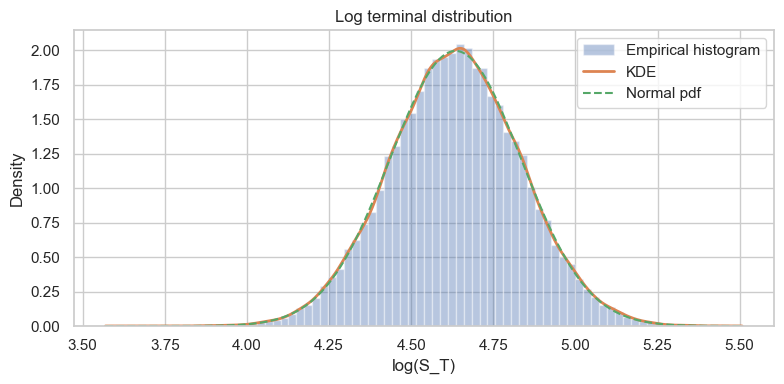

In [8]:
log_S_T = np.log(S_T)

plt.figure(figsize=(8, 4))
plt.hist(log_S_T, bins=80, density=True, alpha=0.4, label="Empirical histogram")

kde_log = gaussian_kde(log_S_T)
x_vals_log = np.linspace(log_S_T.min(), log_S_T.max(), 500)
plt.plot(x_vals_log, kde_log(x_vals_log), label="KDE", linewidth=2)

mean_log = np.log(S0) + (mu - 0.5 * sigma**2) * T
std_log = sigma * np.sqrt(T)
plt.plot(
    x_vals_log,
    norm.pdf(x_vals_log, loc=mean_log, scale=std_log),
    label="Normal pdf",
    linestyle="--",
)

plt.xlabel("log(S_T)")
plt.ylabel("Density")
plt.title("Log terminal distribution")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["gbm"], "gbm_log_terminal_distribution.png"), dpi=150)
plt.show()

## 2) Correlated GBM: empirical correlation vs target


Target correlation:
[[1.  0.7]
 [0.7 1. ]]
Empirical correlation:
[[1.     0.6928]
 [0.6928 1.    ]]


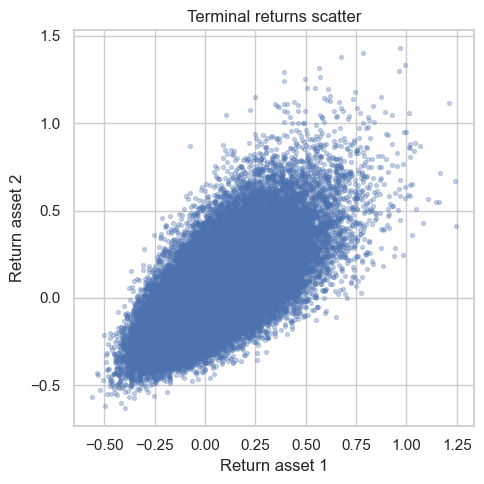

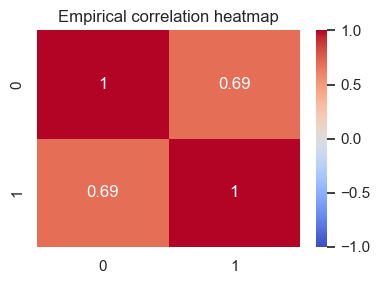

In [9]:
S0_vec = np.array([S0, S0])
mu_vec = np.array([mu, mu * 0.8])
sigma_vec = np.array([sigma, sigma * 1.1])
corr_matrix = np.array([[1.0, corr], [corr, 1.0]])

t_grid_multi, paths_multi = simulate_correlated_gbm_paths(
    S0=S0_vec,
    mu=mu_vec,
    sigma=sigma_vec,
    corr_matrix=corr_matrix,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=seed,
)

S_T_multi = paths_multi[:, -1, :]
R_T_multi = S_T_multi / S0_vec - 1.0
emp_corr = np.corrcoef(R_T_multi.T)
print("Target correlation:")
print(corr_matrix)
print("Empirical correlation:")
print(emp_corr)

plt.figure(figsize=(5, 5))
plt.scatter(R_T_multi[:, 0], R_T_multi[:, 1], alpha=0.3, s=8)
plt.xlabel("Return asset 1")
plt.ylabel("Return asset 2")
plt.title("Terminal returns scatter")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["corr"], "corr_scatter.png"), dpi=150)
plt.show()

plt.figure(figsize=(4, 3))
sns.heatmap(emp_corr, vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.title("Empirical correlation heatmap")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["corr"], "corr_heatmap.png"), dpi=150)
plt.show()

### Correlated GBM terminal distributions


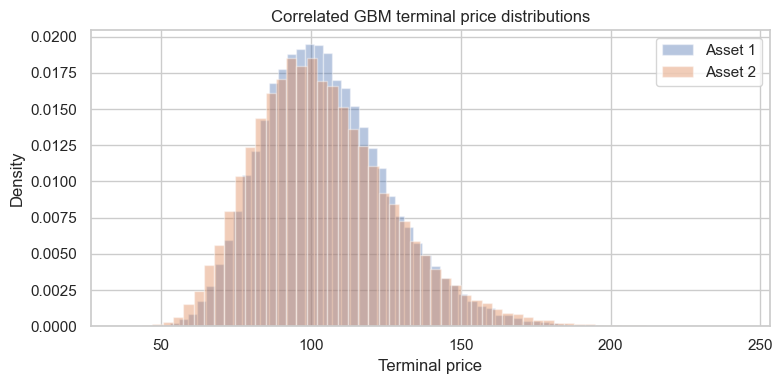

In [10]:
S_T_multi = paths_multi[:, -1, :]

plt.figure(figsize=(8, 4))
for i in range(S_T_multi.shape[1]):
    plt.hist(S_T_multi[:, i], bins=60, density=True, alpha=0.4, label=f"Asset {i + 1}")

plt.xlabel("Terminal price")
plt.ylabel("Density")
plt.title("Correlated GBM terminal price distributions")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["corr"], "corr_terminal_distributions.png"), dpi=150)
plt.show()

### Sample correlated paths


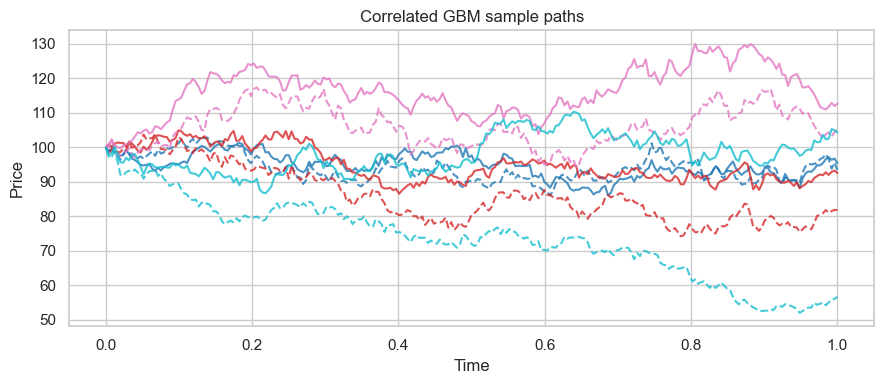

In [11]:
plt.figure(figsize=(9, 4))
colors = plt.cm.tab10(np.linspace(0, 1, 4))
for p, color in zip(range(4), colors):
    plt.plot(t_grid_multi, paths_multi[p, :, 0], color=color, linestyle="-", alpha=0.8)
    plt.plot(t_grid_multi, paths_multi[p, :, 1], color=color, linestyle="--", alpha=0.8)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Correlated GBM sample paths")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["corr"], "corr_sample_paths.png"), dpi=150)
plt.show()

## 3) European option pricing: MC vs Black-Scholes


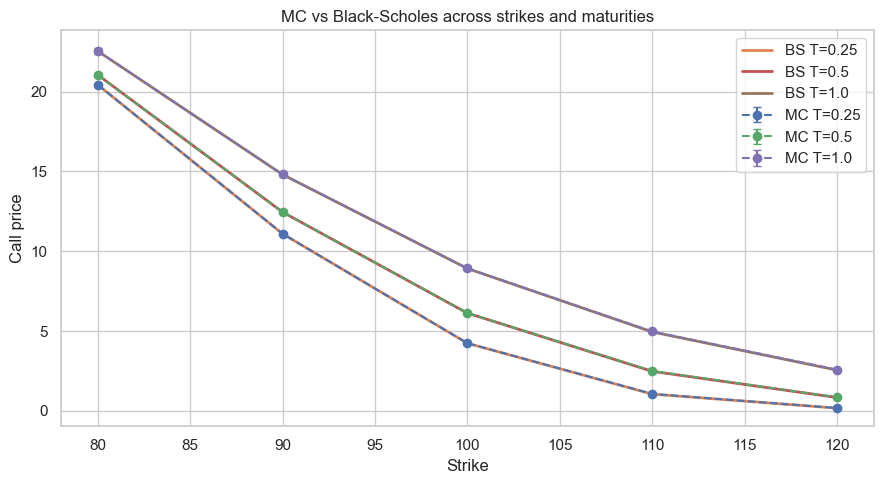

In [12]:
mc_prices_by_T = {}
mc_ci_by_T = {}
bs_prices_by_T = {}

for T_i in maturities:
    mc_prices = []
    mc_ci = []
    bs_prices = []
    for K in strikes:
        res = mc_european_call(
            S0=S0,
            K=K,
            T=T_i,
            r=r,
            sigma=sigma,
            n_steps=n_steps,
            n_paths=n_paths,
            seed=seed,
            return_details=True,
        )
        mc_prices.append(res.price)
        mc_ci.append(1.959963984540054 * res.stderr)
        bs_prices.append(black_scholes_call(S0, K, T_i, r, sigma))
    mc_prices_by_T[T_i] = mc_prices
    mc_ci_by_T[T_i] = mc_ci
    bs_prices_by_T[T_i] = bs_prices

plt.figure(figsize=(9, 5))
for T_i in maturities:
    plt.errorbar(
        strikes,
        mc_prices_by_T[T_i],
        yerr=mc_ci_by_T[T_i],
        marker="o",
        linestyle="--",
        capsize=3,
        label=f"MC T={T_i}",
    )
    plt.plot(strikes, bs_prices_by_T[T_i], linewidth=2, label=f"BS T={T_i}")

plt.xlabel("Strike")
plt.ylabel("Call price")
plt.title("MC vs Black-Scholes across strikes and maturities")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pricing"], "mc_vs_bs_strikes_maturities.png"), dpi=150)
plt.show()

## 4) Discounted payoff distribution


### Discounted payoff distribution


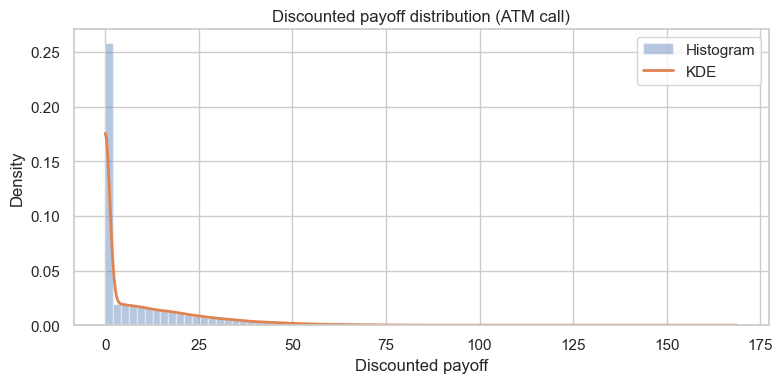

In [13]:
n_paths_dist = 200_000
S_T_dist = simulate_gbm_terminal(S0, r, sigma, T_ref, n_paths_dist, seed=seed)
discounted_payoffs = np.exp(-r * T_ref) * payoff_call(S_T_dist, K_atm)

plt.figure(figsize=(8, 4))
plt.hist(discounted_payoffs, bins=80, density=True, alpha=0.4, label="Histogram")

kde_payoff = gaussian_kde(discounted_payoffs)
x_vals = np.linspace(discounted_payoffs.min(), discounted_payoffs.max(), 500)
plt.plot(x_vals, kde_payoff(x_vals), label="KDE", linewidth=2)

plt.xlabel("Discounted payoff")
plt.ylabel("Density")
plt.title("Discounted payoff distribution (ATM call)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["ci"], "discounted_payoff_distribution.png"), dpi=150)
plt.show()

## 5) Convergence and confidence intervals


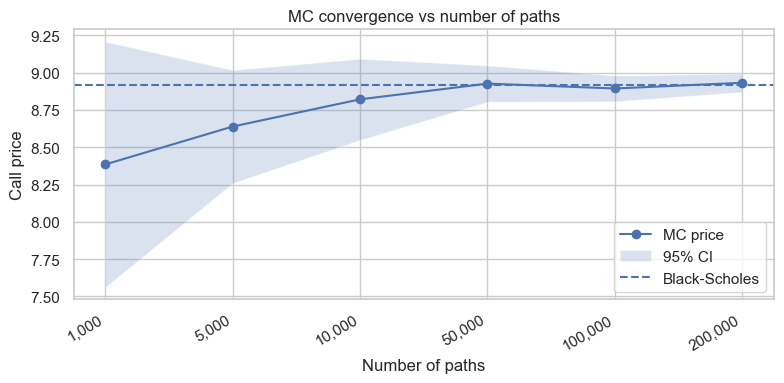

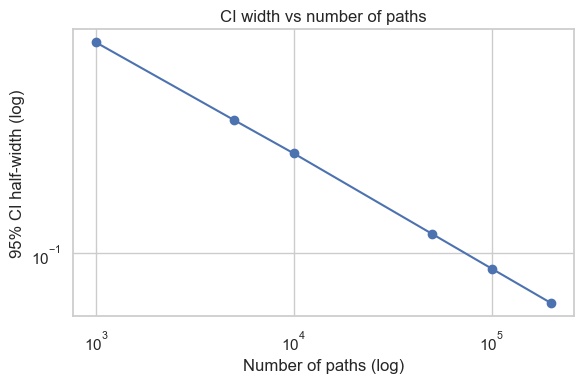

In [14]:
n_paths_grid = [1_000, 5_000, 10_000, 50_000, 100_000, 200_000]
K_atm = S0
T_ref = maturities[-1]

prices = []
ci_half_width = []
abs_err = []

bs_ref = black_scholes_call(S0, K_atm, T_ref, r, sigma)

for n in n_paths_grid:
    res = mc_european_call(
        S0=S0,
        K=K_atm,
        T=T_ref,
        r=r,
        sigma=sigma,
        n_steps=n_steps,
        n_paths=n,
        seed=seed,
        return_details=True,
    )
    prices.append(res.price)
    ci_half_width.append(1.959963984540054 * res.stderr)
    abs_err.append(abs(res.price - bs_ref))

x = np.arange(len(n_paths_grid))
plt.figure(figsize=(8, 4))
plt.plot(x, prices, marker="o", label="MC price")
plt.fill_between(
    x,
    np.array(prices) - np.array(ci_half_width),
    np.array(prices) + np.array(ci_half_width),
    alpha=0.2,
    label="95% CI",
)
plt.axhline(bs_ref, linestyle="--", label="Black-Scholes")
plt.xticks(x, [f"{n:,}" for n in n_paths_grid], rotation=30, ha="right")
plt.xlabel("Number of paths")
plt.ylabel("Call price")
plt.title("MC convergence vs number of paths")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["ci"], "mc_convergence_paths.png"), dpi=150)
plt.show()

plt.figure(figsize=(6, 4))
plt.loglog(n_paths_grid, ci_half_width, marker="o")
plt.xlabel("Number of paths (log)")
plt.ylabel("95% CI half-width (log)")
plt.title("CI width vs number of paths")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["ci"], "ci_width_vs_paths.png"), dpi=150)
plt.show()

### CI width vs 1/sqrt(N) reference


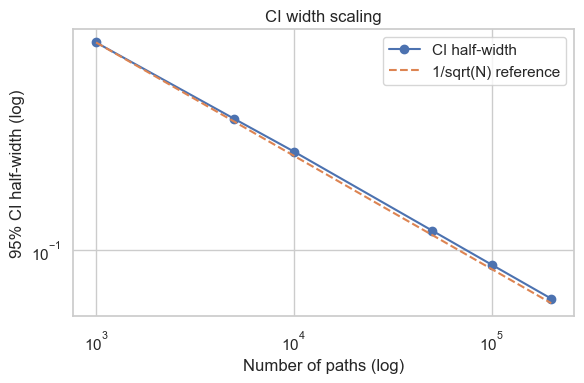

In [15]:
ci_ref = ci_half_width[0] * (np.sqrt(n_paths_grid[0]) / np.sqrt(np.array(n_paths_grid)))
plt.figure(figsize=(6, 4))
plt.loglog(n_paths_grid, ci_half_width, marker="o", label="CI half-width")
plt.loglog(n_paths_grid, ci_ref, linestyle="--", label="1/sqrt(N) reference")
plt.xlabel("Number of paths (log)")
plt.ylabel("95% CI half-width (log)")
plt.title("CI width scaling")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["ci"], "ci_width_scaling.png"), dpi=150)
plt.show()

## 6) Variance reduction


### CI width vs paths (variance reduction)


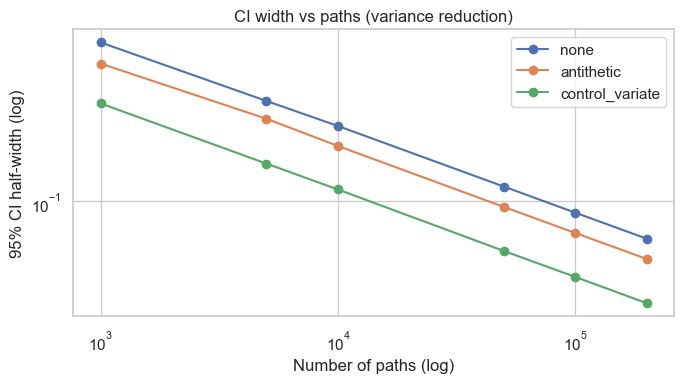

In [16]:
methods = ["none", "antithetic", "control_variate"]
ci_by_method = {m: [] for m in methods}

for m in methods:
    for n in n_paths_grid:
        res = mc_european_call(
            S0=S0,
            K=K_atm,
            T=T_ref,
            r=r,
            sigma=sigma,
            n_steps=n_steps,
            n_paths=n,
            seed=seed,
            variance_reduction=m,
            return_details=True,
        )
        ci_by_method[m].append(1.959963984540054 * res.stderr)

plt.figure(figsize=(7, 4))
for m in methods:
    plt.plot(n_paths_grid, ci_by_method[m], marker="o", label=m)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of paths (log)")
plt.ylabel("95% CI half-width (log)")
plt.title("CI width vs paths (variance reduction)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["vr"], "ci_width_vs_paths_vr.png"), dpi=150)
plt.show()

### MC convergence with and without variance reduction


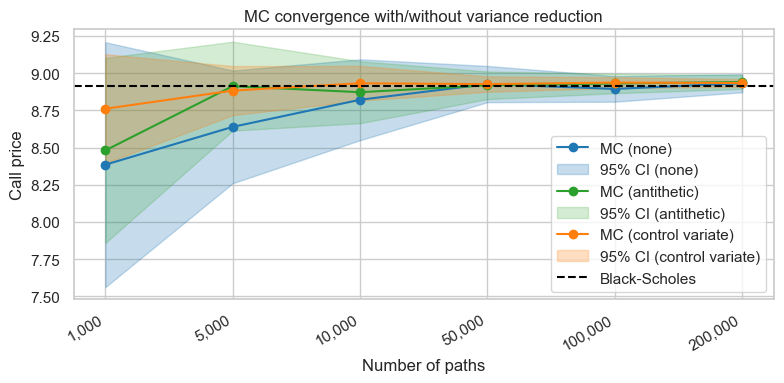

In [17]:
prices_plain = []
ci_plain = []
prices_cv = []
prices_anti = []
ci_cv = []
ci_anti = []

for n in n_paths_grid:
    res_plain = mc_european_call(
        S0=S0,
        K=K_atm,
        T=T_ref,
        r=r,
        sigma=sigma,
        n_steps=n_steps,
        n_paths=n,
        seed=seed,
        variance_reduction='none',
        return_details=True,
    )
    res_anti = mc_european_call(
        S0=S0,
        K=K_atm,
        T=T_ref,
        r=r,
        sigma=sigma,
        n_steps=n_steps,
        n_paths=n,
        seed=seed,
        variance_reduction='antithetic',
        return_details=True,
    )
    res_cv = mc_european_call(
        S0=S0,
        K=K_atm,
        T=T_ref,
        r=r,
        sigma=sigma,
        n_steps=n_steps,
        n_paths=n,
        seed=seed,
        variance_reduction='control_variate',
        return_details=True,
    )
    prices_plain.append(res_plain.price)
    ci_plain.append(1.959963984540054 * res_plain.stderr)
    prices_anti.append(res_anti.price)
    ci_anti.append(1.959963984540054 * res_anti.stderr)
    prices_cv.append(res_cv.price)
    ci_cv.append(1.959963984540054 * res_cv.stderr)

x = np.arange(len(n_paths_grid))
plt.figure(figsize=(8, 4))
plt.plot(x, prices_plain, marker='o', color='tab:blue', label='MC (none)')
plt.fill_between(
    x,
    np.array(prices_plain) - np.array(ci_plain),
    np.array(prices_plain) + np.array(ci_plain),
    alpha=0.25,
    color='tab:blue',
    label='95% CI (none)',
)
plt.plot(x, prices_anti, marker='o', color='tab:green', label='MC (antithetic)')
plt.fill_between(
    x,
    np.array(prices_anti) - np.array(ci_anti),
    np.array(prices_anti) + np.array(ci_anti),
    alpha=0.2,
    color='tab:green',
    label='95% CI (antithetic)',
)
plt.plot(x, prices_cv, marker='o', color='tab:orange', label='MC (control variate)')
plt.fill_between(
    x,
    np.array(prices_cv) - np.array(ci_cv),
    np.array(prices_cv) + np.array(ci_cv),
    alpha=0.25,
    color='tab:orange',
    label='95% CI (control variate)',
)
plt.axhline(bs_ref, linestyle='--', color='black', label='Black-Scholes')
plt.xticks(x, [f'{n:,}' for n in n_paths_grid], rotation=30, ha='right')
plt.xlabel('Number of paths')
plt.ylabel('Call price')
plt.title('MC convergence with/without variance reduction')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['vr'], 'mc_convergence_ci_vr.png'), dpi=150)
plt.show()


### Absolute error vs number of paths


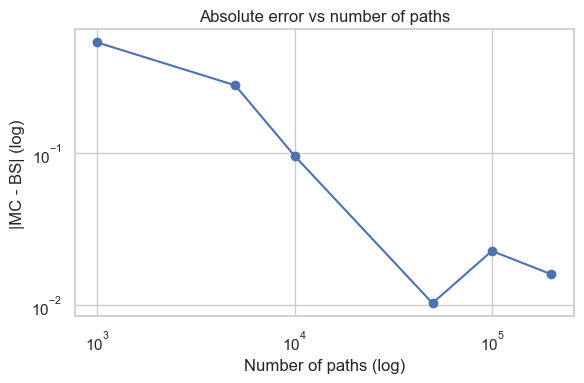

In [18]:
plt.figure(figsize=(6, 4))
plt.loglog(n_paths_grid, abs_err, marker="o")
plt.xlabel("Number of paths (log)")
plt.ylabel("|MC - BS| (log)")
plt.title("Absolute error vs number of paths")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["ci"], "mc_abs_error_vs_paths.png"), dpi=150)
plt.show()

## 7) Greeks validation


### Greeks vs Black-Scholes (strike sweep)


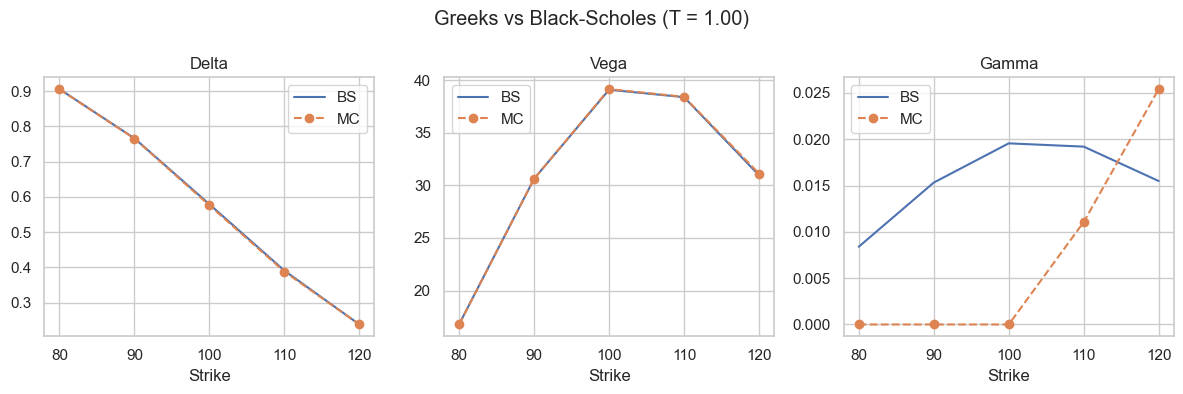

In [19]:
T_g = maturities[-1]
n_paths_g = 80_000

mc_delta_vals = []
mc_vega_vals = []
mc_gamma_vals = []
bs_delta_vals = []
bs_vega_vals = []
bs_gamma_vals = []

for K in strikes:
    mc_delta_vals.append(
        delta_pathwise_call(S0, K, T_g, r, sigma, n_paths_g, seed=seed, return_details=False)
    )
    mc_vega_vals.append(
        vega_fd_call(S0, K, T_g, r, sigma, n_paths_g, seed=seed, return_details=False)
    )
    mc_gamma_vals.append(
        gamma_fd_call(S0, K, T_g, r, sigma, n_paths_g, seed=seed, return_details=False)
    )
    bs_delta_vals.append(bs_delta_call(S0, K, T_g, r, sigma))
    bs_vega_vals.append(bs_vega(S0, K, T_g, r, sigma))
    bs_gamma_vals.append(bs_gamma(S0, K, T_g, r, sigma))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(strikes, bs_delta_vals, label='BS')
axes[0].plot(strikes, mc_delta_vals, marker='o', linestyle='--', label='MC')
axes[0].set_title('Delta')
axes[0].set_xlabel('Strike')

axes[1].plot(strikes, bs_vega_vals, label='BS')
axes[1].plot(strikes, mc_vega_vals, marker='o', linestyle='--', label='MC')
axes[1].set_title('Vega')
axes[1].set_xlabel('Strike')

axes[2].plot(strikes, bs_gamma_vals, label='BS')
axes[2].plot(strikes, mc_gamma_vals, marker='o', linestyle='--', label='MC')
axes[2].set_title('Gamma')
axes[2].set_xlabel('Strike')

for ax in axes:
    ax.legend()

fig.suptitle('Greeks vs Black-Scholes (T = %.2f)' % T_g)
fig.tight_layout()
fig.savefig(os.path.join(section_dirs['greeks'], 'greeks_vs_bs_strikes.png'), dpi=150)
plt.show()


### Gamma finite-difference bump sweep (bias vs variance)


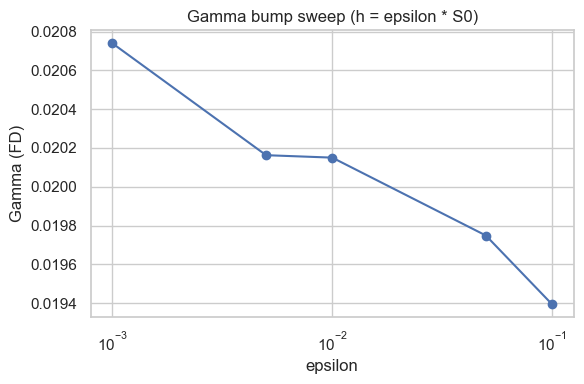

In [20]:
eps_values = [1e-1, 5e-2,1e-2, 5e-3, 1e-3]
bump_values = [eps * S0 for eps in eps_values]

gamma_est = []
for bump in bump_values:
    gamma_est.append(
        gamma_fd_call(S0, K_atm, T_ref, r, sigma, n_paths_g, seed=seed, bump=bump, return_details=False)
    )

plt.figure(figsize=(6, 4))
plt.plot(eps_values, gamma_est, marker='o')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('Gamma (FD)')
plt.title('Gamma bump sweep (h = epsilon * S0)')
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'gamma_bump_sweep.png'), dpi=150)
plt.show()


### Gamma MC vs Black-Scholes (h = 1e-2 * S0)


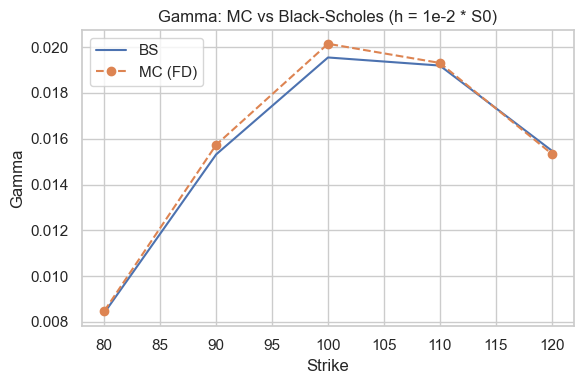

In [21]:
bump_gamma = 1e-2 * S0

mc_gamma_vals = []
bs_gamma_vals = []
for K in strikes:
    mc_gamma_vals.append(
        gamma_fd_call(S0, K, T_g, r, sigma, n_paths_g, seed=seed, bump=bump_gamma, return_details=False)
    )
    bs_gamma_vals.append(bs_gamma(S0, K, T_g, r, sigma))

plt.figure(figsize=(6, 4))
plt.plot(strikes, bs_gamma_vals, label='BS')
plt.plot(strikes, mc_gamma_vals, marker='o', linestyle='--', label='MC (FD)')
plt.xlabel('Strike')
plt.ylabel('Gamma')
plt.title('Gamma: MC vs Black-Scholes (h = 1e-2 * S0)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'gamma_mc_vs_bs_h1e2.png'), dpi=150)
plt.show()


### Greeks convergence vs number of paths


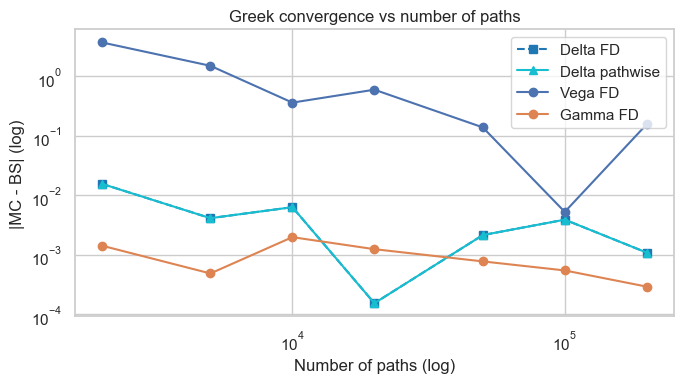

In [22]:
n_paths_list = [2_000, 5_000, 10_000, 20_000, 50_000, 100_000, 200_000]
bump_opt = 1e-2 * S0

bs_delta_ref = bs_delta_call(S0, K_atm, T_ref, r, sigma)
bs_vega_ref = bs_vega(S0, K_atm, T_ref, r, sigma)
bs_gamma_ref = bs_gamma(S0, K_atm, T_ref, r, sigma)

err_delta_fd = []
err_delta_pw = []
err_vega_fd = []
err_gamma_fd = []

for n in n_paths_list:
    delta_fd = delta_fd_call(S0, K_atm, T_ref, r, sigma, n, seed=seed, bump=1e-4, return_details=False)
    delta_pw = delta_pathwise_call(S0, K_atm, T_ref, r, sigma, n, seed=seed, return_details=False)
    vega_fd = vega_fd_call(S0, K_atm, T_ref, r, sigma, n, seed=seed, bump=1e-4, return_details=False)
    gamma_fd = gamma_fd_call(S0, K_atm, T_ref, r, sigma, n, seed=seed, bump=bump_opt, return_details=False)

    err_delta_fd.append(abs(delta_fd - bs_delta_ref))
    err_delta_pw.append(abs(delta_pw - bs_delta_ref))
    err_vega_fd.append(abs(vega_fd - bs_vega_ref))
    err_gamma_fd.append(abs(gamma_fd - bs_gamma_ref))

plt.figure(figsize=(7, 4))
plt.plot(n_paths_list, err_delta_fd, marker='s', linestyle='--', color='tab:blue', label='Delta FD')
plt.plot(n_paths_list, err_delta_pw, marker='^', linestyle='-', color='tab:cyan', label='Delta pathwise')
plt.plot(n_paths_list, err_vega_fd, marker='o', label='Vega FD')
plt.plot(n_paths_list, err_gamma_fd, marker='o', label='Gamma FD')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of paths (log)')
plt.ylabel('|MC - BS| (log)')
plt.title('Greek convergence vs number of paths')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'greeks_error_vs_paths.png'), dpi=150)
plt.show()


### Greeks variability across seeds


/tmp/ipykernel_10941/4208301382.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([delta_fd_vals, delta_pw_vals], labels=['Delta FD', 'Delta pathwise'])


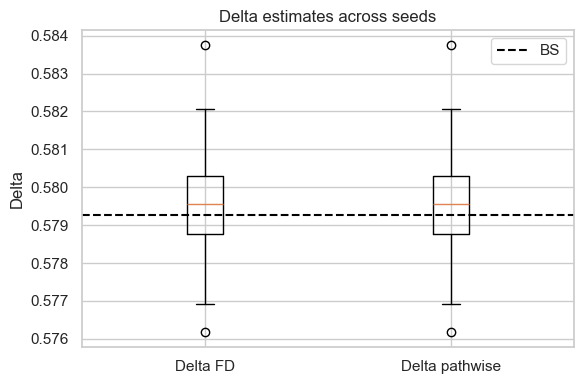

/tmp/ipykernel_10941/4208301382.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([vega_fd_vals], labels=['Vega FD'])


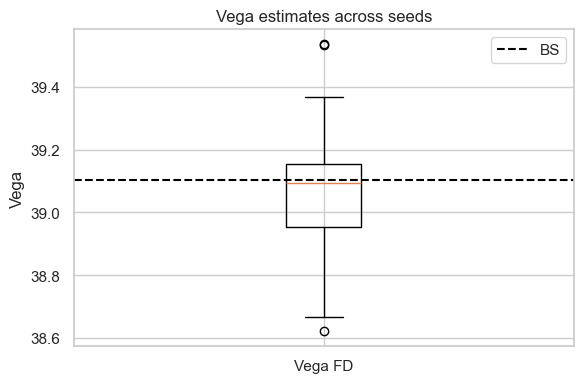

/tmp/ipykernel_10941/4208301382.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gamma_fd_vals], labels=['Gamma FD'])


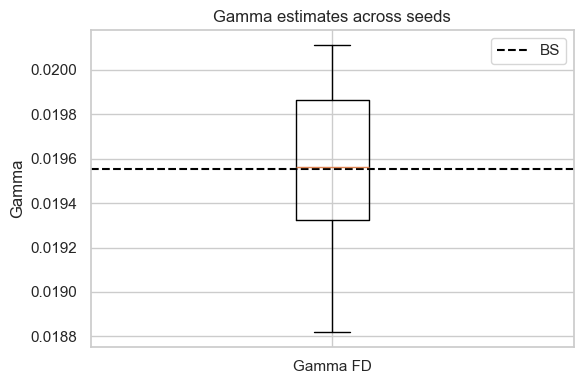

In [23]:
seed_list = list(range(30))
n_paths_stab = 100_000
bump_opt = 1e-2 * S0

delta_fd_vals = []
delta_pw_vals = []
vega_fd_vals = []
gamma_fd_vals = []

for s in seed_list:
    delta_fd_vals.append(delta_fd_call(S0, K_atm, T_ref, r, sigma, n_paths_stab, seed=s, bump=1e-4, return_details=False))
    delta_pw_vals.append(delta_pathwise_call(S0, K_atm, T_ref, r, sigma, n_paths_stab, seed=s, return_details=False))
    vega_fd_vals.append(vega_fd_call(S0, K_atm, T_ref, r, sigma, n_paths_stab, seed=s, bump=1e-4, return_details=False))
    gamma_fd_vals.append(gamma_fd_call(S0, K_atm, T_ref, r, sigma, n_paths_stab, seed=s, bump=bump_opt, return_details=False))

plt.figure(figsize=(6, 4))
plt.boxplot([delta_fd_vals, delta_pw_vals], labels=['Delta FD', 'Delta pathwise'])
plt.axhline(bs_delta_call(S0, K_atm, T_ref, r, sigma), color='black', linestyle='--', label='BS')
plt.title('Delta estimates across seeds')
plt.ylabel('Delta')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'greeks_distribution_across_seeds_delta.png'), dpi=150)
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot([vega_fd_vals], labels=['Vega FD'])
plt.axhline(bs_vega(S0, K_atm, T_ref, r, sigma), color='black', linestyle='--', label='BS')
plt.title('Vega estimates across seeds')
plt.ylabel('Vega')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'greeks_distribution_across_seeds_vega.png'), dpi=150)
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot([gamma_fd_vals], labels=['Gamma FD'])
plt.axhline(bs_gamma(S0, K_atm, T_ref, r, sigma), color='black', linestyle='--', label='BS')
plt.title('Gamma estimates across seeds')
plt.ylabel('Gamma')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'greeks_distribution_across_seeds_gamma.png'), dpi=150)
plt.show()


### Gamma relative error heatmap (moneyness vs maturity)


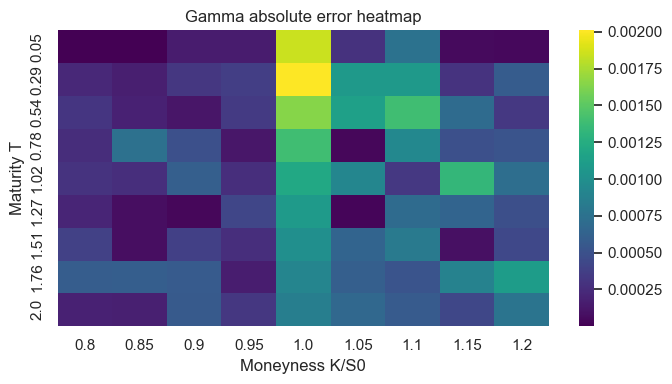

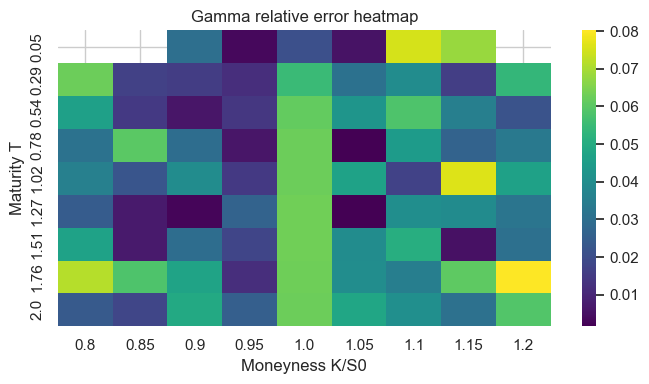

In [24]:
moneyness_grid = np.linspace(0.8, 1.2, 9)
T_grid = np.linspace(0.05, 2.0, 9)
n_paths_heat = 40_000
bump_opt = 1e-2 * S0

bs_grid = np.zeros((len(T_grid), len(moneyness_grid)))
mc_grid = np.zeros((len(T_grid), len(moneyness_grid)))

for i, T_h in enumerate(T_grid):
    for j, m in enumerate(moneyness_grid):
        K_h = m * S0
        bs_g = bs_gamma(S0, K_h, T_h, r, sigma)
        mc_g = gamma_fd_call(S0, K_h, T_h, r, sigma, n_paths_heat, seed=seed, bump=bump_opt, return_details=False)
        bs_grid[i, j] = bs_g
        mc_grid[i, j] = mc_g

nonzero = np.abs(bs_grid) > 0
if np.any(nonzero):
    tau = 0.01 * np.median(np.abs(bs_grid[nonzero]))
else:
    tau = 1e-5

abs_err = np.abs(mc_grid - bs_grid)
rel_err = abs_err / np.maximum(np.abs(bs_grid), tau)

mask = np.abs(bs_grid) < tau
rel_err = rel_err.astype(float)
rel_err[mask] = np.nan

plt.figure(figsize=(7, 4))
ax = sns.heatmap(abs_err, xticklabels=np.round(moneyness_grid, 2), yticklabels=np.round(T_grid, 2), cmap='viridis')
ax.set_xlabel('Moneyness K/S0')
ax.set_ylabel('Maturity T')
ax.set_title('Gamma absolute error heatmap')
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'gamma_abs_error_heatmap.png'), dpi=150)
plt.show()

plt.figure(figsize=(7, 4))
ax = sns.heatmap(rel_err, xticklabels=np.round(moneyness_grid, 2), yticklabels=np.round(T_grid, 2), cmap='viridis')
ax.set_xlabel('Moneyness K/S0')
ax.set_ylabel('Maturity T')
ax.set_title('Gamma relative error heatmap')
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'gamma_rel_error_heatmap.png'), dpi=150)
plt.show()


### Delta noise vs paths (variance reduction)


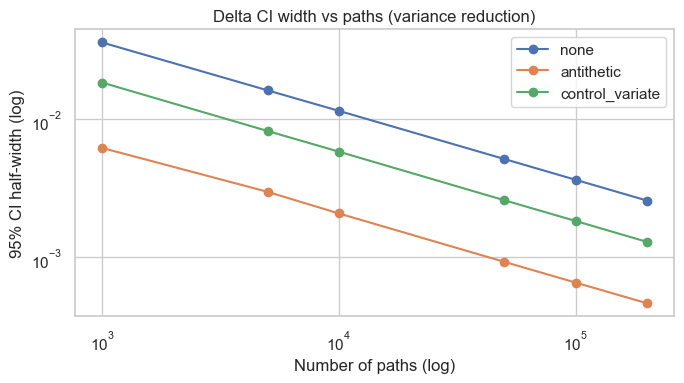

In [25]:
delta_ci = {m: [] for m in ['none', 'antithetic', 'control_variate']}

for m in delta_ci:
    for n in n_paths_grid:
        res = delta_pathwise_call(
            S0,
            K_atm,
            T_ref,
            r,
            sigma,
            n,
            seed=seed,
            variance_reduction=m,
            return_details=True,
        )
        delta_ci[m].append(1.959963984540054 * res.stderr)

plt.figure(figsize=(7, 4))
for m, vals in delta_ci.items():
    plt.plot(n_paths_grid, vals, marker='o', label=m)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of paths (log)')
plt.ylabel('95% CI half-width (log)')
plt.title('Delta CI width vs paths (variance reduction)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs['greeks'], 'delta_ci_vs_paths.png'), dpi=150)
plt.show()


## 8) Portfolio VaR & ES

- PnL is defined as portfolio value at horizon minus initial value (PnL = V_T - V_0).
- VaR is reported as a positive loss threshold: VaR_alpha = -quantile_{1-alpha}(PnL).
- ES is the average loss beyond VaR, also reported as a positive number.


In [26]:
S0_vec_port = np.array(S0_vec_var, dtype=float)
sigma_vec_port = np.array(sigma_vec_var, dtype=float)
mu_vec_port = np.array(mu_vec_var, dtype=float)
corr_matrix_port = np.array(corr_matrix_var, dtype=float)
weights = np.array(w_var, dtype=float)

if not np.isclose(weights.sum(), 1.0):
    weights = weights / weights.sum()

pnl = simulate_portfolio_pnl(
    S0=S0_vec_port,
    mu=mu_vec_port,
    sigma=sigma_vec_port,
    corr_matrix=corr_matrix_port,
    weights=weights,
    T=T_var,
    n_steps=n_steps_var,
    n_paths=n_paths_var,
    seed=seed_var,
)


### PnL histogram with VaR and ES


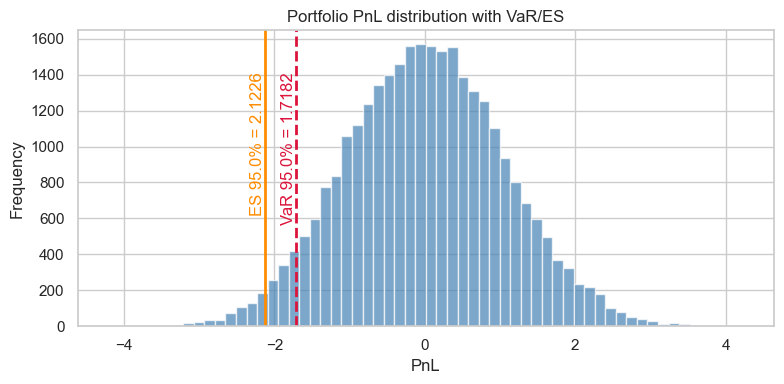

In [27]:
var_alpha = empirical_var(pnl, alpha=alpha_var)
es_alpha = empirical_es(pnl, alpha=alpha_var)

plt.figure(figsize=(8, 4))
counts, bins, _ = plt.hist(pnl, bins=60, alpha=0.7, color="steelblue")
plt.axvline(-var_alpha, color="crimson", linestyle="--", linewidth=2)
plt.axvline(-es_alpha, color="darkorange", linestyle="-", linewidth=2)

y_max = counts.max() if len(counts) else 1.0
plt.text(-var_alpha, 0.9 * y_max, f"VaR {alpha_var:.1%} = {var_alpha:.4f}",
         rotation=90, va="top", ha="right", color="crimson")
plt.text(-es_alpha, 0.9 * y_max, f"ES {alpha_var:.1%} = {es_alpha:.4f}",
         rotation=90, va="top", ha="right", color="darkorange")

plt.title("Portfolio PnL distribution with VaR/ES")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["risk"], "var_es_pnl_hist_alpha095.png"), dpi=150)
plt.show()


### VaR and ES vs confidence level


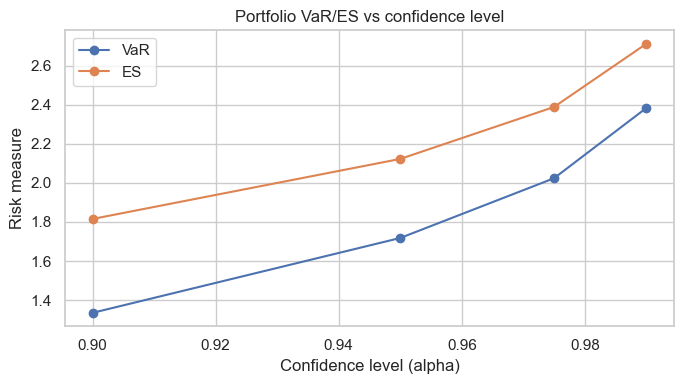

In [28]:
alphas = np.array(alpha_list, dtype=float)
var_curve, es_curve = var_es_curve(pnl, alphas)

plt.figure(figsize=(7, 4))
plt.plot(alphas, var_curve, marker="o", label="VaR")
plt.plot(alphas, es_curve, marker="o", label="ES")
plt.title("Portfolio VaR/ES vs confidence level")
plt.xlabel("Confidence level (alpha)")
plt.ylabel("Risk measure")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["risk"], "var_es_vs_alpha.png"), dpi=150)
plt.show()


### Diversification stress: VaR/ES vs correlation


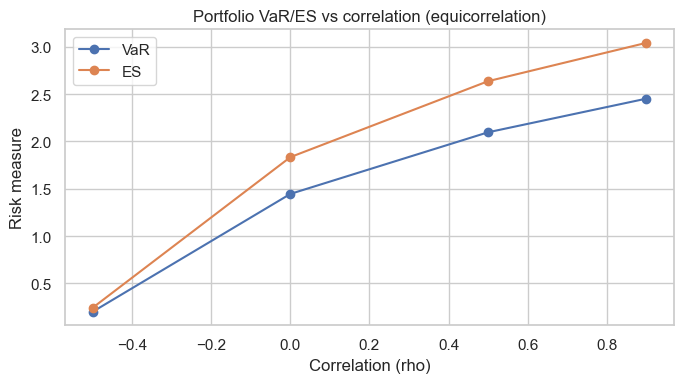

In [29]:
rho_list = [-0.5, 0.0, 0.5, 0.9]
n_paths_rho = 8_000

var_rho = []
es_rho = []

d = S0_vec_port.size
I = np.eye(d)
ones = np.ones((d, d))

for i, rho in enumerate(rho_list):
    corr_rho = (1.0 - rho) * I + rho * ones
    pnl_rho = simulate_portfolio_pnl(
        S0=S0_vec_port,
        mu=mu_vec_port,
        sigma=sigma_vec_port,
        corr_matrix=corr_rho,
        weights=weights,
        T=T_var,
        n_steps=n_steps_var,
        n_paths=n_paths_rho,
        seed=seed_var + i,
    )
    var_rho.append(empirical_var(pnl_rho, alpha=alpha_var))
    es_rho.append(empirical_es(pnl_rho, alpha=alpha_var))

plt.figure(figsize=(7, 4))
plt.plot(rho_list, var_rho, marker="o", label="VaR")
plt.plot(rho_list, es_rho, marker="o", label="ES")
plt.title("Portfolio VaR/ES vs correlation (equicorrelation)")
plt.xlabel("Correlation (rho)")
plt.ylabel("Risk measure")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["risk"], "var_es_vs_correlation.png"), dpi=150)
plt.show()


## 9) Black--Scholes PDE benchmark (Crank--Nicolson)

- Boundary conditions are enforced at S=0 and S=S_max for each time step.
- Call: V(t,0)=0 and V(t,S_max)=S_max-K*exp(-r*(T-t)).
- Put: V(t,0)=K*exp(-r*(T-t)) and V(t,S_max)=0.


In [30]:
pde_strikes = np.array(strikes, dtype=float)
S_max_pde = pde_S_max_mult * max(S0, pde_strikes.max())

bs_prices = []
mc_prices = []
pde_prices = []

for i, K_val in enumerate(pde_strikes):
    bs_prices.append(black_scholes_call(S0, K_val, T_pde, r, sigma))
    mc_prices.append(
        mc_european_call(
            S0,
            K_val,
            T_pde,
            r,
            sigma,
            n_steps,
            n_paths_mc_pde,
            seed=seed_pde + i,
            return_details=False,
        )
    )
    pde_prices.append(
        price_bs_pde_cn(
            S0,
            K_val,
            T_pde,
            r,
            sigma,
            option_type="call",
            n_S=n_S_pde,
            n_t=n_t_pde,
            S_max=S_max_pde,
        )
    )

bs_prices = np.array(bs_prices)
mc_prices = np.array(mc_prices)
pde_prices = np.array(pde_prices)


### PDE vs BS absolute error


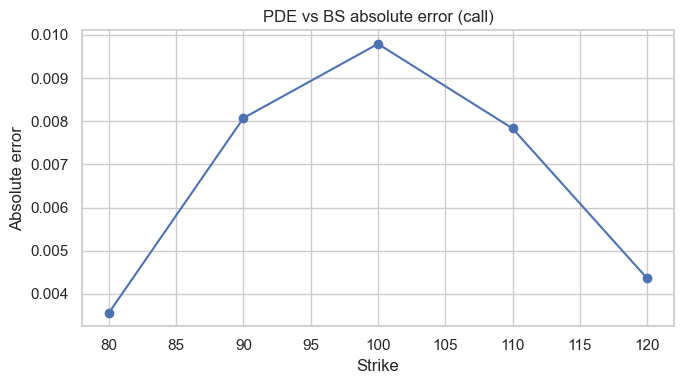

In [31]:
pde_abs_error = np.abs(pde_prices - bs_prices)

plt.figure(figsize=(7, 4))
plt.plot(pde_strikes, pde_abs_error, marker="o")
plt.title("PDE vs BS absolute error (call)")
plt.xlabel("Strike")
plt.ylabel("Absolute error")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pde"], "pde_vs_bs_abs_error.png"), dpi=150)
plt.show()


### Triangulation: BS vs MC vs PDE


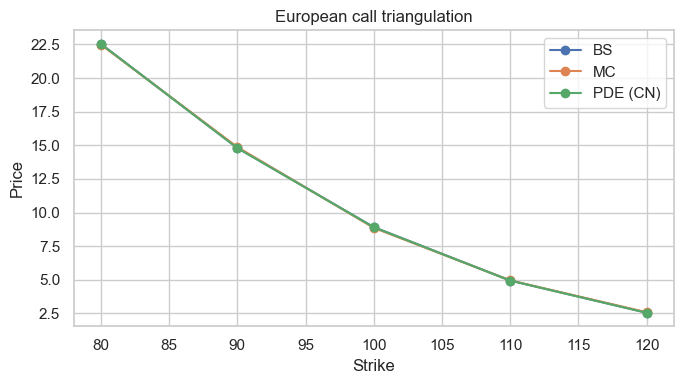

In [32]:
plt.figure(figsize=(7, 4))
plt.plot(pde_strikes, bs_prices, marker="o", label="BS")
plt.plot(pde_strikes, mc_prices, marker="o", label="MC")
plt.plot(pde_strikes, pde_prices, marker="o", label="PDE (CN)")
plt.title("European call triangulation")
plt.xlabel("Strike")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pde"], "pde_mc_bs_triangulation.png"), dpi=150)
plt.show()


### PDE convergence vs grid resolution


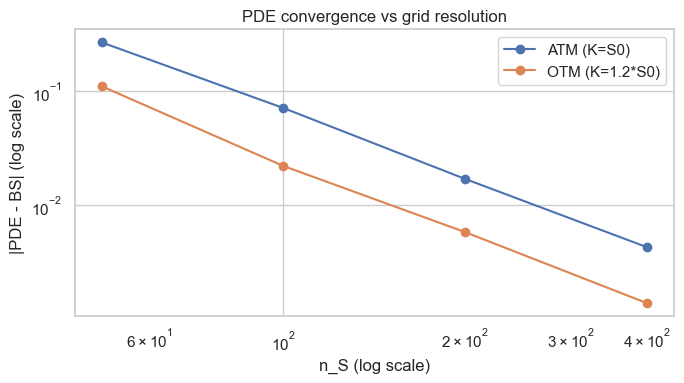

In [33]:
grid_sizes = [(50, 50), (100, 100), (200, 200), (400, 400)]

K_atm_pde = S0
K_otm_pde = 1.2 * S0
T_conv = T_pde
S_max_conv = pde_S_max_mult * max(S0, K_otm_pde)

errors_atm = []
errors_otm = []
grid_labels = []

for n_S, n_t in grid_sizes:
    pde_atm = price_bs_pde_cn(
        S0, K_atm_pde, T_conv, r, sigma,
        option_type="call", n_S=n_S, n_t=n_t, S_max=S_max_conv,
    )
    pde_otm = price_bs_pde_cn(
        S0, K_otm_pde, T_conv, r, sigma,
        option_type="call", n_S=n_S, n_t=n_t, S_max=S_max_conv,
    )
    bs_atm = black_scholes_call(S0, K_atm_pde, T_conv, r, sigma)
    bs_otm = black_scholes_call(S0, K_otm_pde, T_conv, r, sigma)
    errors_atm.append(abs(pde_atm - bs_atm))
    errors_otm.append(abs(pde_otm - bs_otm))
    grid_labels.append(n_S)

plt.figure(figsize=(7, 4))
plt.plot(grid_labels, errors_atm, marker="o", label="ATM (K=S0)")
plt.plot(grid_labels, errors_otm, marker="o", label="OTM (K=1.2*S0)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n_S (log scale)")
plt.ylabel("|PDE - BS| (log scale)")
plt.title("PDE convergence vs grid resolution")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pde"], "pde_error_vs_grid.png"), dpi=150)
plt.show()


### PDE error vs moneyness across maturities


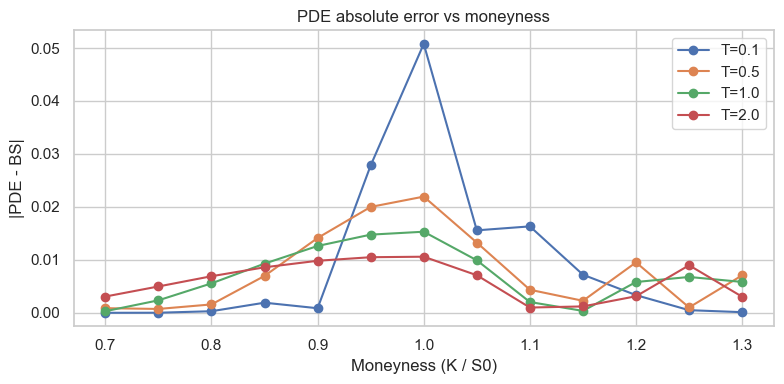

In [34]:
T_list = [0.1, 0.5, 1.0, 2.0]
moneyness_grid = np.linspace(0.7, 1.3, 13)

n_S_diag = min(n_S_pde, 200)
n_t_diag = min(n_t_pde, 200)

plt.figure(figsize=(8, 4))
for T_val in T_list:
    errors = []
    for m in moneyness_grid:
        K_val = m * S0
        S_max_local = pde_S_max_mult * max(S0, K_val)
        pde_price = price_bs_pde_cn(
            S0, K_val, T_val, r, sigma,
            option_type="call", n_S=n_S_diag, n_t=n_t_diag, S_max=S_max_local,
        )
        bs_price = black_scholes_call(S0, K_val, T_val, r, sigma)
        errors.append(abs(pde_price - bs_price))
    plt.plot(moneyness_grid, errors, marker="o", label=f"T={T_val}")

plt.title("PDE absolute error vs moneyness")
plt.xlabel("Moneyness (K / S0)")
plt.ylabel("|PDE - BS|")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pde"], "pde_error_vs_moneyness_multiT.png"), dpi=150)
plt.show()


### PDE price curve vs BS (optional)


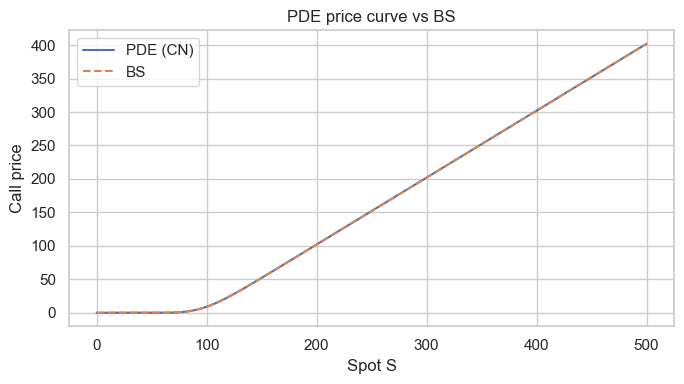

In [35]:
K_curve = S0
T_curve = T_pde
S_max_curve = pde_S_max_mult * max(S0, K_curve)

n_S_curve = min(n_S_pde, 300)
n_t_curve = min(n_t_pde, 300)

S_grid, V0 = solve_bs_pde_cn(
    S0, K_curve, T_curve, r, sigma,
    option_type="call", n_S=n_S_curve, n_t=n_t_curve, S_max=S_max_curve,
    return_full_grid=False,
)

bs_curve = np.array([0.0 if S <= 0.0 else black_scholes_call(S, K_curve, T_curve, r, sigma) for S in S_grid])

plt.figure(figsize=(7, 4))
plt.plot(S_grid, V0, label="PDE (CN)")
plt.plot(S_grid, bs_curve, linestyle="--", label="BS")
plt.title("PDE price curve vs BS")
plt.xlabel("Spot S")
plt.ylabel("Call price")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pde"], "pde_price_curve_vs_bs.png"), dpi=150)
plt.show()


### PDE Delta vs MC Delta


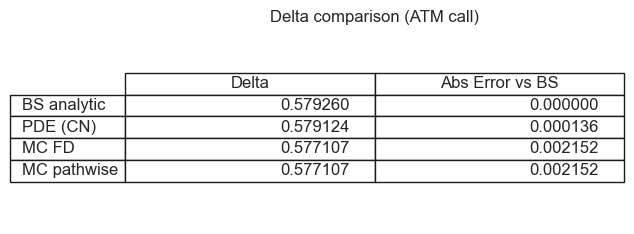

In [36]:
def pde_delta_at_S0(S0, K, T, r, sigma, n_S, n_t, S_max):
    S_grid, V0 = solve_bs_pde_cn(
        S0, K, T, r, sigma,
        option_type="call", n_S=n_S, n_t=n_t, S_max=S_max,
        return_t0_grid=True,
    )
    delta = np.empty_like(V0)
    delta[0] = (V0[1] - V0[0]) / (S_grid[1] - S_grid[0])
    delta[-1] = (V0[-1] - V0[-2]) / (S_grid[-1] - S_grid[-2])
    delta[1:-1] = (V0[2:] - V0[:-2]) / (S_grid[2:] - S_grid[:-2])
    return float(np.interp(S0, S_grid, delta))

S0_delta = S0
K_delta = S0
T_delta = T_pde
S_max_delta = pde_S_max_mult * max(S0_delta, K_delta)
n_S_delta = min(n_S_pde, 300)
n_t_delta = min(n_t_pde, 300)

delta_bs = bs_delta_call(S0_delta, K_delta, T_delta, r, sigma)
delta_pde = pde_delta_at_S0(S0_delta, K_delta, T_delta, r, sigma, n_S_delta, n_t_delta, S_max_delta)
delta_mc_fd = delta_fd_call(
    S0_delta, K_delta, T_delta, r, sigma,
    n_paths=50_000, seed=seed, return_details=False,
)
delta_mc_pw = delta_pathwise_call(
    S0_delta, K_delta, T_delta, r, sigma,
    n_paths=50_000, seed=seed, return_details=False,
)

rows = ["BS analytic", "PDE (CN)", "MC FD", "MC pathwise"]
vals = [delta_bs, delta_pde, delta_mc_fd, delta_mc_pw]
errs = [0.0, abs(delta_pde - delta_bs), abs(delta_mc_fd - delta_bs), abs(delta_mc_pw - delta_bs)]

fig, ax = plt.subplots(figsize=(6.5, 2.5))
ax.axis("off")
cell_text = [[f"{v:.6f}", f"{e:.6f}"] for v, e in zip(vals, errs)]
table = ax.table(
    cellText=cell_text,
    rowLabels=rows,
    colLabels=["Delta", "Abs Error vs BS"],
    loc="center",
)
table.scale(1.0, 1.3)
plt.title("Delta comparison (ATM call)")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pde"], "delta_pde_vs_mc_single_case.png"), dpi=150)
plt.show()


### PDE Delta convergence vs grid


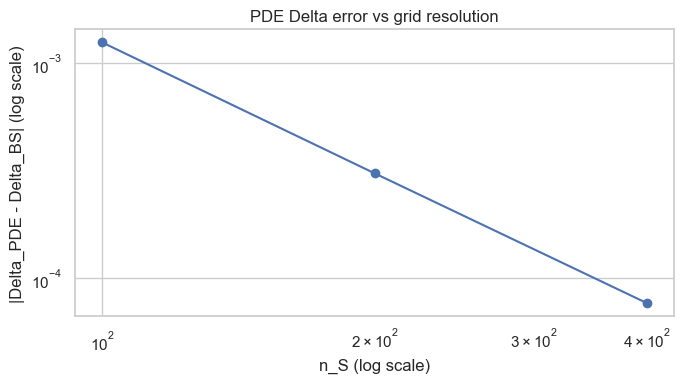

In [37]:
grid_sizes = [(100, 100), (200, 200), (400, 400)]
delta_errors = []
grid_labels = []

for n_S, n_t in grid_sizes:
    delta_pde = pde_delta_at_S0(S0_delta, K_delta, T_delta, r, sigma, n_S, n_t, S_max_delta)
    delta_errors.append(abs(delta_pde - delta_bs))
    grid_labels.append(n_S)

plt.figure(figsize=(7, 4))
plt.plot(grid_labels, delta_errors, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n_S (log scale)")
plt.ylabel("|Delta_PDE - Delta_BS| (log scale)")
plt.title("PDE Delta error vs grid resolution")
plt.tight_layout()
plt.savefig(os.path.join(section_dirs["pde"], "delta_error_vs_grid.png"), dpi=150)
plt.show()
